## Set up Environment and Load Data

In [0]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score  
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Digits Dataset

In [0]:
digits = load_digits()
X = digits.data
y = digits.target
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Simple NN

In [0]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), len(np.unique(y))))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [0]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [0]:
def f(z):
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [0]:
def default(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [0]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

### Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [0]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

### Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [0]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

### The Back Propagation Algorithm


In [0]:
iter = 1500

In [0]:
def train_nn(nn_structure, X, y, iter_num=iter, alpha=0.25, lamb=0.01, setup_and_init_weights=default):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    acc_func = []
    print('alpha:', alpha, 'lambda:', lamb, 'weight initialization:', setup_and_init_weights)
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            # W[l] += -alpha * (1.0/N * tri_W[l])
            # b[l] += -alpha * (1.0/N * tri_b[l])
            # add regularization
            W[l] += -alpha * (1.0/N * tri_W[l] + lamb/2 * W[l]) 
            b[l] += -alpha * (1.0/N * tri_b[l])
        #acc_func.append(acc())
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func, acc_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [0]:
def acc():
  # get the prediction accuracy and print
  y_pred = predict_y(W, b, X_test, 3)
  #print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
  return accuracy_score(y_test, y_pred)

def plot():
  # plot the avg_cost_func
  plt.plot(avg_cost_func)
  plt.ylabel('Average J')
  plt.xlabel('Iteration number')
  plt.show()

In [0]:
nn_structure = [X.shape[1], 30, len(np.unique(y))]
nn_structure 

[64, 30, 10]

### Run NN

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5358993e18>
Starting gradient descent for 1500 iterations
Iteration 0 of 1500
Iteration 1000 of 1500
CPU times: user 2min 33s, sys: 36.9 ms, total: 2min 34s
Wall time: 2min 34s


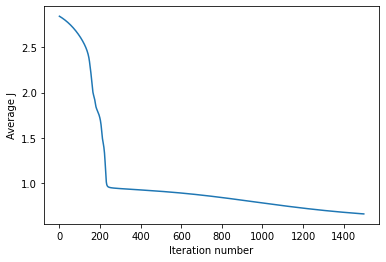

0.8444444444444444

In [0]:
# train the NN
%time W, b, avg_cost_func, acc_func = train_nn(nn_structure, X_train, y_v_train)

plot()
acc()

## SGD with Momentum

In [0]:
def train_nn_mom(nn_structure, X, y, iter_num=iter, alpha=0.25, lamb=0.01, mom=0.9, setup_and_init_weights=default):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    acc_func = []
    print('alpha:', alpha, 'lambda:', lamb, 'weight initialization:', setup_and_init_weights)
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            # add regularization
            delta = -alpha * (1.0/N * tri_W[l] + lamb/2 * W[l])
            if l > 2:
              prev_delta = -alpha * (1.0/N * tri_W[l-1] + lamb/2 * W[l-1])
            else:
              prev_delta = 0
            W[l] += delta + (mom * prev_delta)
            b[l] += -alpha * (1.0/N * tri_b[l])
        #acc_func.append(acc())
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func, acc_func

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5358993e18>
Starting gradient descent for 1500 iterations
Iteration 0 of 1500
Iteration 1000 of 1500
CPU times: user 2min 34s, sys: 41.9 ms, total: 2min 34s
Wall time: 2min 34s


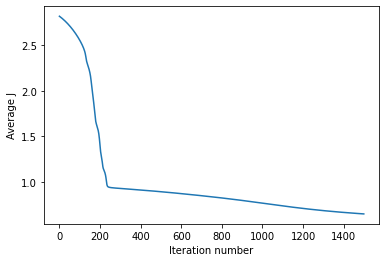

0.8555555555555555

In [0]:
%time W, b, avg_cost_func, acc_func = train_nn_mom(nn_structure, X_train, y_v_train)

plot()
acc()

# Iris Datset


In [0]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
print("The shape of the iris dataset:") 
print(iris.data.shape)
y = iris.target

X_scale = StandardScaler()
X = X_scale.fit_transform(iris.data)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

nn_structure = [X.shape[1], 30, len(np.unique(y))]

The shape of the iris dataset:
(150, 4)


### Simple NN

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5358993e18>
Starting gradient descent for 1500 iterations
Iteration 0 of 1500
Iteration 1000 of 1500
CPU times: user 12.3 s, sys: 26 ms, total: 12.3 s
Wall time: 12.3 s


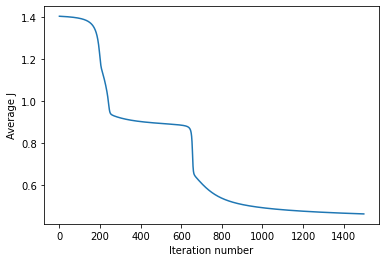

0.8157894736842105

In [0]:
# train the NN
%time W, b, avg_cost_func, acc_func = train_nn(nn_structure, X_train, y_v_train)

plot()
acc()

## SGD with Momentum

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5358993e18>
Starting gradient descent for 1500 iterations
Iteration 0 of 1500
Iteration 1000 of 1500
CPU times: user 12.3 s, sys: 22 ms, total: 12.3 s
Wall time: 12.3 s


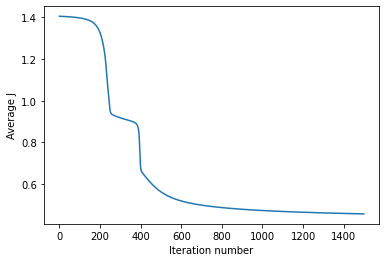

0.868421052631579

In [0]:
%time W, b, avg_cost_func, acc_func = train_nn_mom(nn_structure, X_train, y_v_train)

plot()
acc()